# Selection of krypton events in terms of S1 and S2

## Author: JJGC

In [1]:
import time
print("Last updated on ", time.asctime())

Last updated on  Sun Aug  5 18:49:38 2018


In [2]:
run_number  = 6268
file_range  = 0, 10000  

input_path  = f"$IC_DATA/kdst"
output_path = f"$IC_DATA/dst"
log_path    = f"$IC_DATA/log"
trigger     = 'trigger1'
tags        = 'v0.9.9_20180802'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [124]:
import os
import time
import datetime 
import numpy as np
import pandas as pd
import tables            as tb
import random
import glob


In [79]:
from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units


In [136]:
from krcal.core.io_functions      import filenames_from_paths
from krcal.core.io_functions      import write_monitor_vars
from krcal.core.histo_functions   import h1, h1d
from krcal.core.kr_types          import PlotLabels
from krcal.core.s1s2_functions    import s1d_from_dst
from krcal.core.s1s2_functions    import s2d_from_dst
from krcal.core.s1s2_functions    import plot_s1histos
from krcal.core.s1s2_functions    import plot_s2histos
from krcal.core.plt_functions     import plot_xy_density
from krcal.core.plt_functions     import plot_s1_vs_z
from krcal.core.plt_functions     import plot_s2_vs_z
from krcal.core.plt_functions     import plot_s2_vs_s1
from krcal.core.plt_functions     import plot_q_vs_s2
from krcal.core.plt_functions     import plot_energy_distributions

### Input/output 

In [8]:
input_dst_filenames, output_dst_filename, log_filename = filenames_from_paths(run_number,
                                                                              input_path,
                                                                              output_path,
                                                                              log_path,
                                                                              trigger,
                                                                              tags,
                                                                              file_range)
                                                                              
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"log file   = {log_filename}")                       

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6268/kdst_0000_6268_trigger1_v0.9.9_20180802_krth.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/kdst/6268/kdst_9999_6268_trigger1_v0.9.9_20180802_krth.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6268_trigger1_0000_9999.h5
log file   = /Users/jjgomezcadenas/Projects/ICDATA/log/log_6268_trigger1_0000_9999.h5


In [9]:
dst_full           = load_dsts(input_dst_filenames, "DST", "Events")

In [10]:
unique_events = ~dst_full.event.duplicated()

number_of_S2s_full  = np.size         (unique_events)
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of S2s   : {number_of_S2s_full} ")
print(f"Total number of events: {number_of_evts_full}")

Total number of S2s   : 3451420 
Total number of events: 2829113


In [11]:
dst_full.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [12]:
ntot = len(dst_full)
print(f"length of dst = {ntot}")

length of dst = 3451420


### Define dictionary to keep monitor vars

In [130]:
monitor_vars = {}

### S1/S2

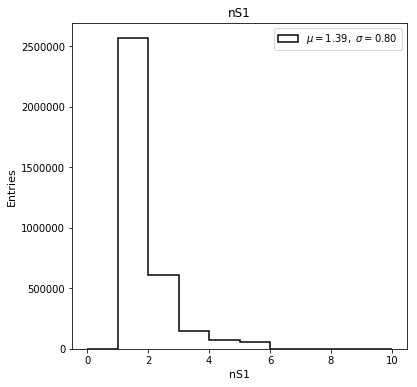

In [14]:
n, b = h1d(dst_full.nS1.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS1', y='Entries', title='nS1'))

In [15]:
fnS1 = n[n.argmax()]/np.sum(n)
print(f'fraction of S1s = {fnS1}')

fraction of S1s = 0.7442096296596763


### Select events with 1 S1

In [16]:
dst1s1 = dst_full[dst_full.nS1==1]

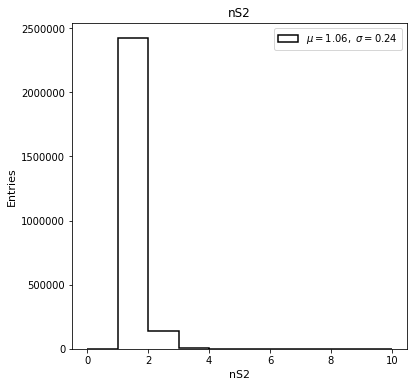

In [17]:
n, b = h1d(dst1s1.nS2.values, bins = 10, range = (0,10),
           pltLabels=PlotLabels(x='nS2', y='Entries', title='nS2'))

In [18]:
fnS2 = n[n.argmax()]/np.sum(n)
print(f'fraction of S2s = {fnS2}')

fraction of S2s = 0.9432526921489695


### Select events with 1 S2

In [19]:
dst    = dst1s1[dst1s1.nS2==1]

In [131]:
monitor_vars['fraction_s1'] = fnS1
monitor_vars['fraction_s2'] = fnS2

In [21]:
n_full   = len(dst)
eff = n_full   / ntot 
print(f"Total number of events with 1 s1 and 1 s2 : {n_full}: selection eff = {eff} ")

Total number of events with 1 s1 and 1 s2 : 2422820: selection eff = 0.7019777366996772 


### S1 and S2 distributions

In [25]:
s1d = s1d_from_dst(dst)

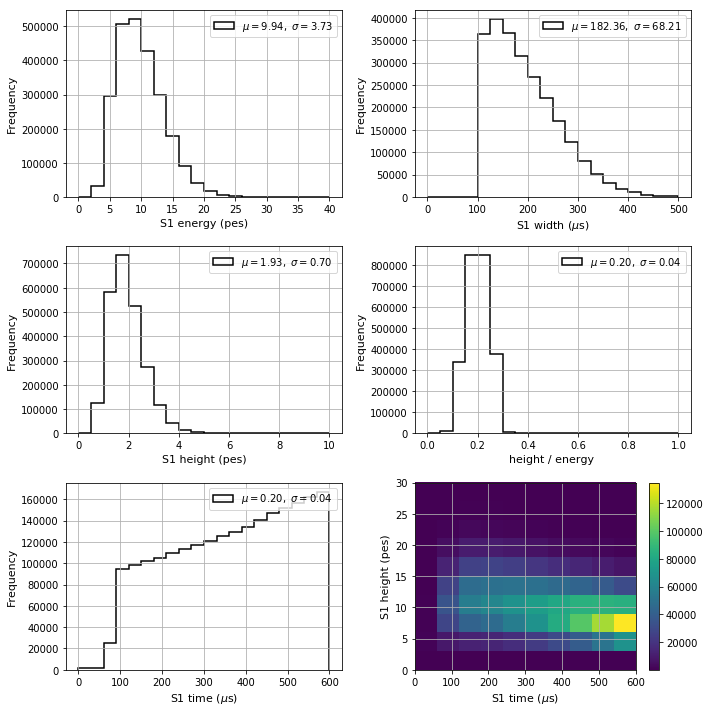

In [27]:
plot_s1histos(dst,  s1d, bins=20, figsize=(10,10))

### Fiducial selection in S1

#### S1e < 22 pes, s1w < 450 mus, S1h < 5 pes, S1t > 150 mus

In [71]:
dst_s1e    = dst[dst.S1e < 25] 
dst_s1w    = dst_s1e[dst_s1e.S1w < 450]
dst_s1h    = dst_s1w[dst_s1w.S1h < 5]
dst_s1t    = dst_s1h[dst_s1h.S1t/units.mus > 150]

In [72]:
s1d = s1d_from_dst(dst_s1h,
                   range_s1e = (0,25),
                   range_s1w = (0,450),
                   range_s1h = (0,5),
                   range_s1t = (160,600))


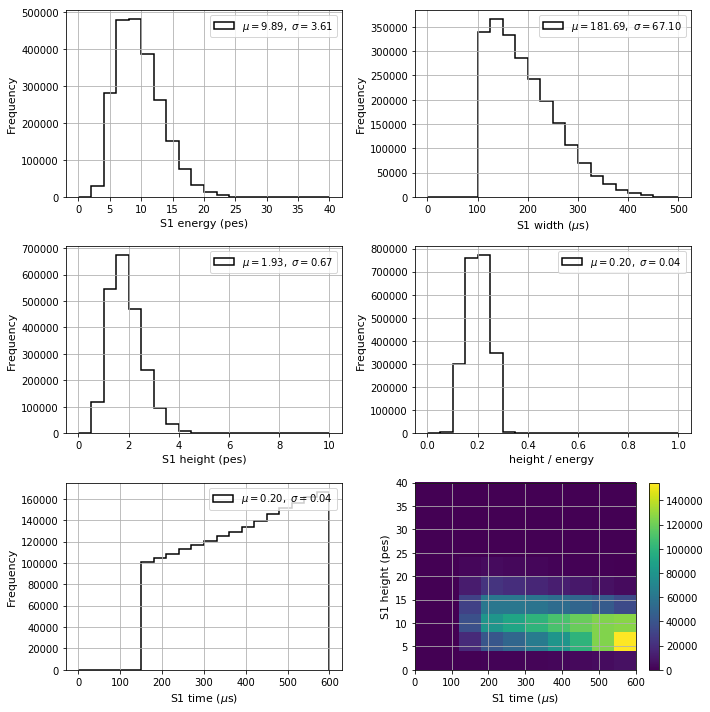

In [73]:
plot_s1histos(dst_s1t,  s1d, bins=20, figsize=(10,10))

In [76]:
dst = dst_s1t

In [77]:
s2d = s2d_from_dst(dst)

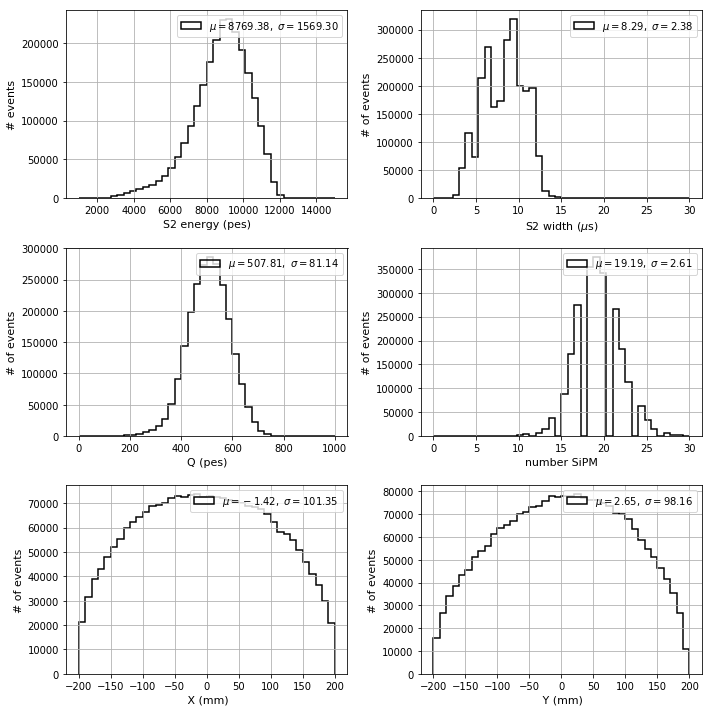

In [78]:
plot_s2histos(dst, s2d, bins=40, emin=1000, emax=15000, figsize=(10,10))

In [132]:
monitor_vars['S1e'] = s1d.E.value
monitor_vars['S2e'] = s2d.E.value
monitor_vars['S2q'] = s2d.Q.value

### Fiducial selection in S2

#### 3000 < S2e < 13000 pes, 5 < s2w < 15 mus, 200 < 800 

In [80]:
dst_s2e    = dst[in_range(dst.S2e, 3000, 13000)] 
dst_s2w    = dst_s2e[in_range(dst_s2e.S2w, 5, 15)]
dst_s2q    = dst_s2w[in_range(dst_s2w.S2q, 200, 800)]

In [83]:
dst = dst_s2q

In [84]:
s2d = s2d_from_dst(dst)

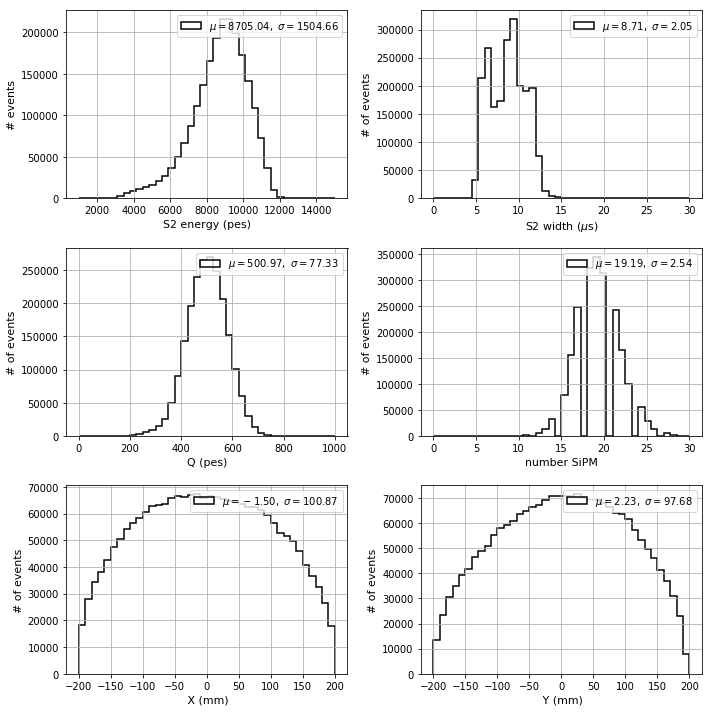

In [85]:
plot_s2histos(dst, s2d, bins=40, emin=1000, emax=15000, figsize=(10,10))

In [110]:
XYrange = (-200,  200)
XYnbins =   100
XYbins  = np.linspace(*XYrange, XYnbins + 1)
XYpitch = np.diff(XYbins)[0]

Zrange  = ( 150,  550)
Znbins  =   10
Zbins  = np.linspace(*Zrange, Znbins + 1)

S1range  = ( 0,  25)
S1nbins  =   20
S1bins   = np.linspace(*S1range, S1nbins + 1)

S2range  = ( 3000,  13000)
S2nbins  =   50
S2bins   = np.linspace(*S2range, S2nbins + 1)

Qrange  = ( 100, 800)
Qnbins  =   50
Qbins   = np.linspace(*Qrange, Qnbins + 1)

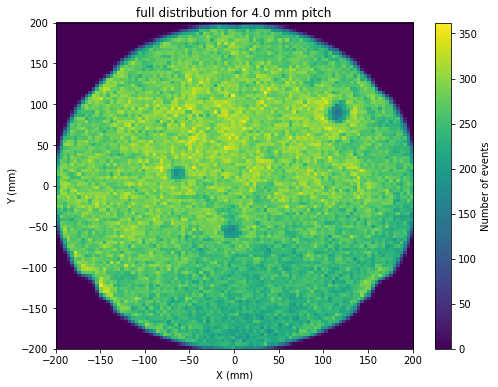

In [105]:
nevt = plot_xy_density(dst, XYbins, figsize=(8,6))

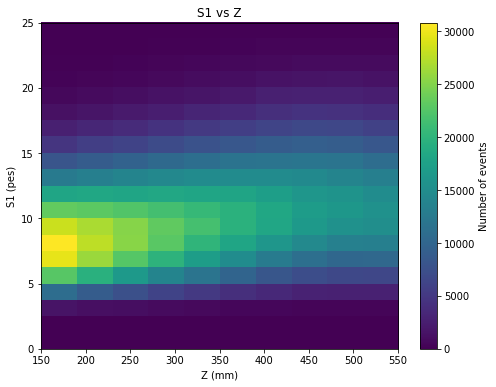

In [106]:
nevt = plot_s1_vs_z(dst, Zbins, S1bins, figsize=(8,6))

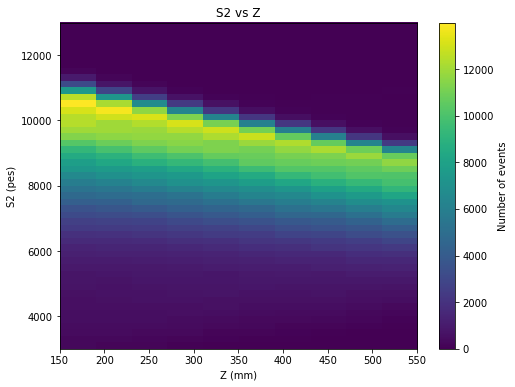

In [107]:
nevt = plot_s2_vs_z(dst, Zbins, S2bins, figsize=(8,6))

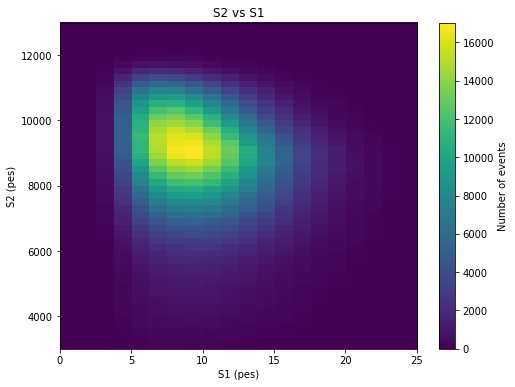

In [108]:
nevt = plot_s2_vs_s1(dst, S1bins, S2bins, figsize=(8,6))

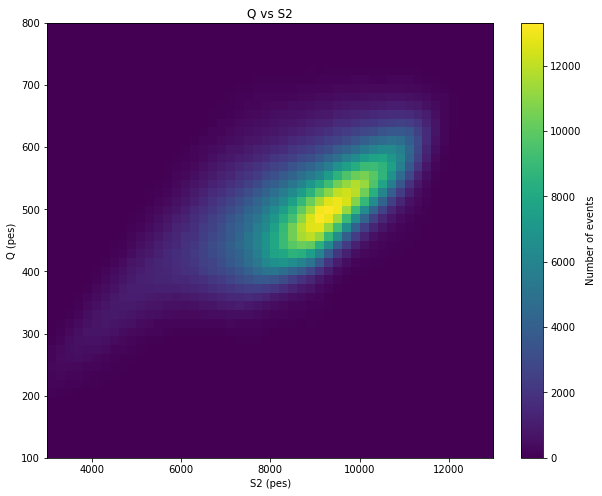

In [111]:
nevt = plot_q_vs_s2(dst, S2bins, Qbins, figsize=(10,8))

### Select central region in R 

In [112]:
dst_R     = dst[dst.R < 100]

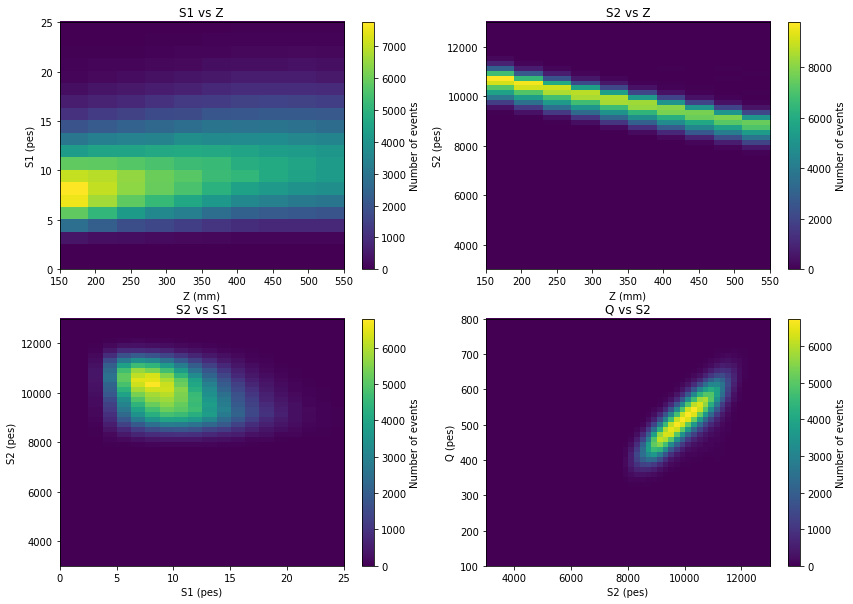

In [115]:
plot_energy_distributions(dst_R, Zbins, S1bins, S2bins, Qbins, figsize=(14,10))

### Select central region in Z

In [116]:
dst_core     = dst_R[dst_R.Z < 200]

### Energy in core

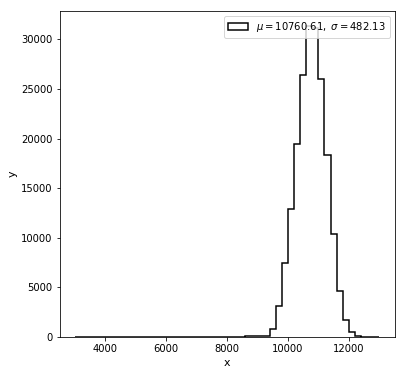

In [118]:
(_) = h1d(dst_core.S2e, bins = 50, range =(3000,13000))

### Write DST (merged and fiducial)

In [121]:
dst.columns

Index(['event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w', 'S1h',
       'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT', 'Z',
       'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

In [ ]:
#del dst['index']

In [122]:
dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)



In [125]:
# Workaround to re-establish the name of the table and its title
with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"

### Write monitor

In [133]:
monitor_vars

{'fraction_s1': 0.7442096296596763,
 'fraction_s2': 0.9432526921489695,
 'S1e': 9.8854610813979,
 'S2e': 8705.042355553365,
 'S2q': 500.9659014645054}

In [134]:
mdf = pd.Series(monitor_vars)

In [135]:
mdf

fraction_s1       0.744210
fraction_s2       0.943253
S1e               9.885461
S2e            8705.042356
S2q             500.965901
dtype: float64

In [137]:
write_monitor_vars(mdf, log_filename)